In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install scikit-learn==1.5.2 xgboost==1.4.2

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

In [ ]:
# Load the saved NumPy arrays
path = '/content/drive/MyDrive/solubility/sol_data_clean/'
X_train_combined = np.load(os.path.join(path, 'X_train_combined.npy'))
X_test_combined = np.load(os.path.join(path, 'X_test_combined.npy'))
Y_train = np.load(os.path.join(path, 'Y_train.npy'))
Y_test = np.load(os.path.join(path, 'Y_test.npy'))

In [ ]:
print(Y_train.shape)
print(X_train_combined.shape)

**Step 1: Initialize the model and train with early stopping**

In [ ]:
xgb_model = XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         max_depth=6,
                         learning_rate=0.01)
xgb_model.fit(
    X_train_combined,
    Y_train,
    eval_set=[(X_test_combined, Y_test)],early_stopping_rounds=50
)


**Step 2: Make predictions on the test set and training set**

In [ ]:
Y_test_pred = xgb_model.predict(X_test_combined)
Y_train_pred = xgb_model.predict(X_train_combined)

**Step 3: Evaluate the model**

In [ ]:
# Calculate Mean Squared Error (MSE), Root MSE (RMSE), R2 and MAE score
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, Y_test_pred)
mae = mean_absolute_error(Y_test, Y_test_pred)

print("Root Mean Squared Error:", rmse)
print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)


In [ ]:
Y_test_pred = Y_test_pred.ravel()
Y_test = Y_test.ravel()
print(Y_test.shape)
print(Y_test_pred.shape)

**Step 4: Create scatter plot**

In [ ]:
sns.set(style="whitegrid")  # Other options: "whitegrid", "white", "dark", "ticks"
# Create a figure with two subplots (1 rows, 2 column)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed vs predicted values in training set
sns.regplot(x=Y_train, y=Y_train_pred, scatter_kws={'s': 50,'color': 'orange'}, line_kws={'color': 'black'},ax=axs[0])
sns.regplot(x=Y_test, y=Y_test_pred, scatter_kws={'s': 50,'color': 'blue'}, line_kws={'color': 'black'},ax=axs[1])

# Add labels and title to the first subplot
axs[0].set_xlabel('Observed log(Aqueous Solubility)', fontsize=16)
axs[0].set_ylabel('Predicted log(Aqueous Solubility)', fontsize=16)
axs[0].set_title('Training Set', fontsize=20)

# Add labels and title to the second subplot
axs[1].set_xlabel('Observed log(Aqueous Solubility)', fontsize=16)
axs[1].set_ylabel('Predicted log(Aqueous Solubility)', fontsize=16)
axs[1].set_title('Test Set', fontsize=20)

# Show the plot
plt.grid(True)
plt.show()

**Step 5: Plot predicted vs. observed plot for test set**

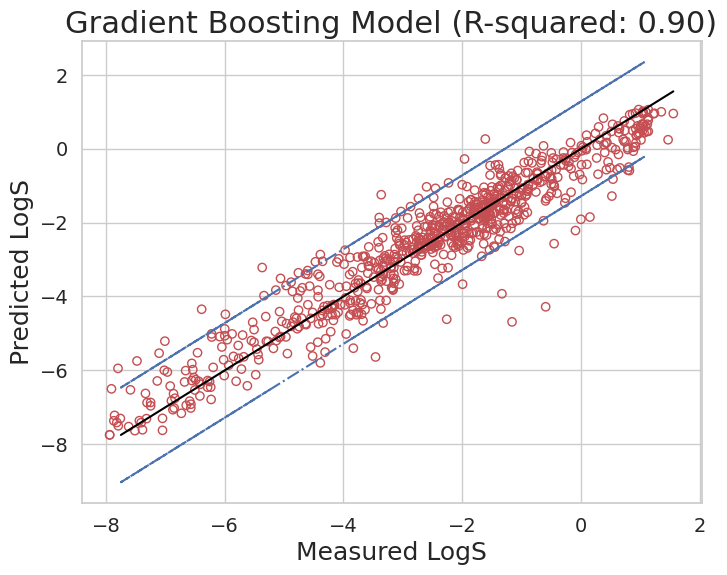

In [ ]:
residuals = Y_test - Y_test_pred
std_residuals = np.std(residuals)
ci_lower = Y_test_pred - 1.96 * std_residuals  # 95% prediction lower bound
ci_upper = Y_test_pred + 1.96 * std_residuals  # 95% prediction upper bound
plt.figure(figsize=(8, 6))
# Plot the observed vs predicted
plt.scatter(Y_test, Y_test_pred, facecolors='none', edgecolors='r')
plt.plot([min(Y_test_pred), max(Y_test)], [min(Y_test_pred), max(Y_test)], color='black')  # Diagonal line
# Plot the 95% CI (upper and lower bounds as lines)
plt.plot(Y_test_pred, ci_upper, color='b', linestyle='-.', label="Upper CI (95%)")
plt.plot(Y_test_pred, ci_lower, color='b', linestyle='-.', label="Lower CI (95%)")

plt.xlabel('Measured LogS', fontsize=18)
plt.ylabel('Predicted LogS', fontsize=18)
# Increase font size of the axis tick labels
plt.tick_params(axis='both', which='major', labelsize=14)  # Font size for major ticks
plt.title(f'Gradient Boosting Model (R-squared: {r2:.2f})', fontsize=22)
plt.show()

**Step 6: Create comparison table**

In [ ]:
import plotly.graph_objects as go
import pandas as pd
# Define the model performance metrics
models = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest Regression', "Gradient Boosting"],
    'RMSE': [0.686, 0.721, 0.654],
    'MAE' : [0.511,  0.521, 0.469],
    'R2' : [0.893,  0.883, 0.903]
})

# Create the Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=models.columns,  # Column headers
        fill_color='lightblue',  # Light blue background for header
        align='center',  # Center align headers
        font=dict(size=18, color='black', family='Arial')  # Font for headers
    ),
    cells=dict(
        values=[models[col] for col in models.columns],  # Cell values
        fill_color=['#f7f7f7', 'white'] * (len(models) // 2 + 1),  # Alternate row colors
        align='center',  # Center align data in cells
        font=dict(size=16, color='black', family='Arial'),  # Font for cells
        height=30  # Adjust row height
    )
)])

# Adjust the column widths manually, setting a smaller width for the second-to-last column (MAE)
fig.update_layout(
    height=600,  # Set height for the table
    width=900,   # Set width for the table
    title="Model Performance Comparison",  # Add title
    title_x=0.5,  # Center the title
)

# Apply column width directly in `go.Table` definition (using a workaround)
fig.data[0].update(
    columnwidth=[150, 100, 100, 100]  # Set width for each column (second-to-last column is narrow)
)

# Show the interactive table
fig.show()

